<a href="https://colab.research.google.com/github/ChristeenaGiji/ai-agents/blob/main/Using_Autogen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install autogen
!pip instralll pyautogen
!pip install dask[dataframe]
import autogen
from autogen import AssistantAgent, UserProxyAgent

ERROR: unknown command "instralll" - maybe you meant "install"


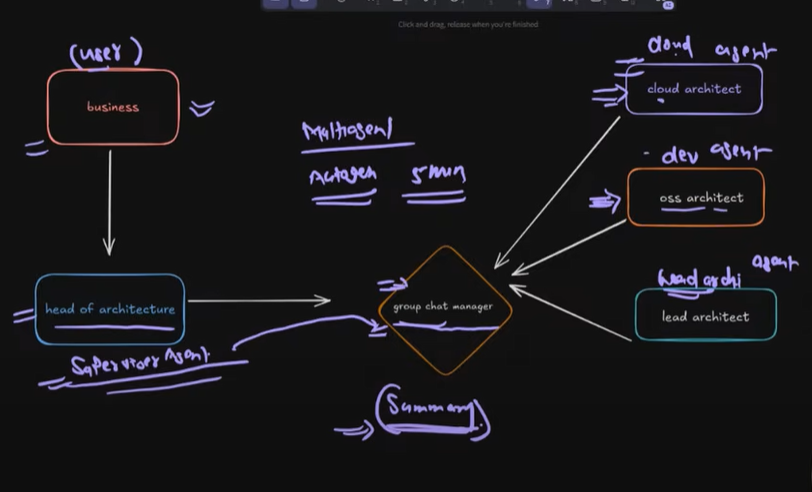

In [83]:
from google.colab import userdata
OPEN_API=userdata.get('GOOGLE_API_KEY')

In [84]:
config_list=[{'model':'gemini-pro','api_key':OPEN_API}]

In [85]:
llm_config={"config_list":config_list}

In [86]:
gpt4o_config ={
    "cache_seed":42,
    "temperature":0,
    "config_list":config_list,
    "timeout":120
}

In [ ]:
task='''
**Task**:As an artitect, youa re required to design a solyution for following business requirements:
- datas tortage for massive ampiunts of Iot data
- real time data analytics and machine learning pipeline
-saclability
-copst optimisation
-region pairs in Europe, for disaster recovery
-tools for monitoring and observability
-timeline: 6  months
break doen the problwem using chain-of-thought approach. ensure that your solutiona rtcheture is following best pratices
'''
cloud_prompt='''
**Role**:You are an expert cloud artichitect.You need to develop architechurte proposols using either cloud-specific PaaS services or clod-agnostic ones.
The final proposol should consider all 3 main cloud providers: Azure,AWS and GCP, and provide a data artichtectures and summarize your solutions for each cloud provider using a table for clarity.
'''
cloud_prompt+=task
oss_prompt ='''
**Role**:You are an expert on-premises,open source software artichitect.You need to develop architechure proposols without considering cloud solutions. Pnly use open source frameworks that are popular and have lots of activr contributoes.At the end,briefly stae the advantages of open source adption, and summarize your solutions using a table for clarity.
'''
oss_prompt +=task
lead_prompt='''
**Role**: You are lead architect tasked with managing a conversation between the cloud and the open source architects.
each architect eill perorm a task and respond woth their results. You will crititcally review those and also ask for, or point to, the disadvantages of theor solutions. You will review each result and choose the best solution in accordance with the business requirements and architechure bet pratices.You will use any number of summary tables to communicate your decision.
'''
lead_prompt+=task
user_proxy=UserProxyAgent(
    name="supervisor",
    system_message="A Human head of architechure",
    code_execution_config={
        "last_n_messages":2,
        "work_dir":"web",
        "use_docker":False
    },
    human_input_mode="NEVER"
)
cloud_agent=AssistantAgent(
    name="cloud",
    system_message=cloud_prompt,
    llm_config={"config_list":config_list}
)

oss_agent=AssistantAgent(
    name="oss",
    system_message=oss_prompt,
    llm_config={"config_list":config_list}
)

lead_agent=AssistantAgent(
    name="lead",
    system_message=lead_prompt,
    llm_config={"config_list":config_list}
)

def state_transition(last_speaker,groupchat):
  messages=groupchat.messages
  if last_speaker is user_proxy:
    return cloud_agent
  elif last_speaker is cloud_agent:
    return oss_agent
  elif last_speaker is oss_agent:
    return lead_agent
  elif last_speaker is lead_agent:
    return None
groupchat=autogen.GroupChat(
    agents=[user_proxy,cloud_agent,oss_agent,lead_agent],
    messages=[],
    max_round=6,
    speaker_selection_method=state_transition
)
manager=autogen.GroupChatManager(groupchat=groupchat,llm_config=llm_config)
user_proxy.initiate_chat(manager,message="Provide your best architecture based on the AI agentfor the business requirements.")

In [ ]:
"supervisor agent --> cloud agent --> oss agent --> leadagent